In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
import shap
import warnings
import matplotlib.pyplot as plt
import empyrical as ep
from datetime import timedelta

# 忽略警告
warnings.filterwarnings('ignore')

# 设置 matplotlib 字体以显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 模型预测部分
# ---------------------------

class LightGBM:
    @staticmethod
    def shap_feature_importance(train_X, train_Y, params, isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier(**params)
            else:
                model = lgb.LGBMRegressor(**params)
            
            model.fit(train_X, train_Y)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(train_X)
            
            # 计算特征重要性
            feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': np.abs(shap_values).mean(axis=0)})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            
            # 可视化特征重要性
            # shap.summary_plot(shap_values, train_X)
            
            return feature_importance_df, shap_values
        except Exception as e:
            print('shap_feature_importance has error: ' + str(e))
            return None, None

    @staticmethod
    def grid_tune(train_X, train_Y, fold_time, isClassifier=True, param_grid=None):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            grid_search = GridSearchCV(estimator=model,
                                       param_grid=param_grid,
                                       cv=tscv,
                                       n_jobs=-1,
                                       scoring=scoring,
                                       verbose=1)
            grid_search.fit(train_X, train_Y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('grid_tune has error: ' + str(e))
            return None, None, None

    @staticmethod
    def random_tune(train_X, train_Y, fold_time, isClassifier=True, param_distributions=None, n_iter=10):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            random_search = RandomizedSearchCV(estimator=model,
                                               param_distributions=param_distributions,
                                               cv=tscv,
                                               n_jobs=-1,
                                               scoring=scoring,
                                               n_iter=n_iter,
                                               verbose=1,
                                               random_state=42)
            random_search.fit(train_X, train_Y)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_results = pd.DataFrame(random_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('random_tune has error: ' + str(e))
            return None, None, None

# 读取数据
df = pd.read_csv('合併資料.csv')

# 将 'Date' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 确保数据按照 'ticker' 和 'Date' 排序
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# 定义目标变量和特征
target = 'Daily_Return'  # 请替换为您的目标变量名称
features = [col for col in df.columns if col not in ['Date', 'ticker', target]]

def train_and_predict_single_ticker(group_df):
    # 确保数据按照日期排序
    group_df = group_df.sort_values('Date').reset_index(drop=True)
    
    # 如果数据量太少，无法训练，则跳过
    if len(group_df) < 20:
        print(f"Ticker {group_df['ticker'].iloc[0]} 数据量不足，跳过")
        return None
    
    # 使用前 80% 的数据作为训练集，后 20% 的数据作为测试集
    split_index = int(len(group_df) * 0.8)
    train = group_df.iloc[:split_index]
    test = group_df.iloc[split_index:]
    
    if len(test) == 0:
        print(f"Ticker {group_df['ticker'].iloc[0]} 测试集为空，跳过")
        return None
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # 模型参数
    params = {
        'boosting_type': 'dart',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'random_state': 7,
        'verbose': 0,
        'min_data_in_leaf':5
    }
    
    # 使用 SHAP 进行特征重要性分析
    try:
        feature_importance_df, shap_values = LightGBM.shap_feature_importance(X_train, y_train, params=params, isClassifier=False)
        if feature_importance_df is not None:
            important_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].tolist()
        else:
            important_features = features  # 如果 SHAP 分析失败，使用所有特征
    except Exception as e:
        print(f'Error during SHAP feature importance analysis for ticker {group_df["ticker"].iloc[0]}: {str(e)}')
        important_features = features
        shap_values = None
    
    # 记录重要特征
    selected_features = important_features.copy()
    
    # 使用重要特征进行模型训练（未调参数）
    X_train_important = X_train[important_features]
    X_test_important = X_test[important_features]
    
    # 初始化模型（未调参数）
    original_model = lgb.LGBMRegressor(**params)
    original_model.fit(X_train_important, y_train)
    
    # 计算训练集 MAE（原始模型）
    y_pred_train = original_model.predict(X_train_important)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的训练集 MAE: {mae_train}")
    
    # 计算测试集 MAE（原始模型）
    y_pred_original = original_model.predict(X_test_important)
    mae_original = mean_absolute_error(y_test, y_pred_original)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的测试集 MAE: {mae_original}")
    
    # 参数调优 - 网格搜索
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }
    
    best_model_grid, best_params_grid, cv_results_grid = LightGBM.grid_tune(X_train_important, y_train, fold_time=5, param_grid=param_grid, isClassifier=False)
    
    if best_model_grid is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 最佳参数: {best_params_grid}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_grid = best_model_grid.predict(X_train_important)
        mae_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_grid = best_model_grid.predict(X_test_important)
        mae_test_grid = mean_absolute_error(y_test, y_pred_test_grid)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 训练集 MAE: {mae_train_grid}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 测试集 MAE: {mae_test_grid}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_grid = original_model
        mae_train_grid = mae_train
        mae_test_grid = mae_original
    
    # 参数调优 - 随机搜索
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7, -1],
        'num_leaves': [31, 63, 127],
        'n_estimators': [50, 100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }
    
    best_model_random, best_params_random, cv_results_random = LightGBM.random_tune(X_train_important, y_train, fold_time=5, param_distributions=param_dist, isClassifier=False, n_iter=10)
    
    if best_model_random is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 最佳参数: {best_params_random}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_random = best_model_random.predict(X_train_important)
        mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_random = best_model_random.predict(X_test_important)
        mae_test_random = mean_absolute_error(y_test, y_pred_test_random)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 训练集 MAE: {mae_train_random}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 测试集 MAE: {mae_test_random}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_random = original_model
        mae_train_random = mae_train
        mae_test_random = mae_original
    
    # 计算 SHAP 值（使用原始模型）
    explainer = shap.TreeExplainer(original_model)
    shap_values = explainer.shap_values(X_train_important)
    
    # 构建结果字典
    result_dict = {
        'ticker': group_df['ticker'].iloc[0],
        'selected_features': selected_features,
        'original_train_mae': mae_train,
        'original_test_mae': mae_original,
        'grid_train_mae': mae_train_grid,
        'grid_test_mae': mae_test_grid,
        'random_train_mae': mae_train_random,
        'random_test_mae': mae_test_random,
        'original_model': original_model,
        'best_model_grid': best_model_grid,
        'best_model_random': best_model_random,
        'y_test': y_test,
        'y_pred_test': y_pred_original,
        'test_dates': test['Date'].values,
        'shap_values': shap_values,
        'shap_feature_names': X_train_important.columns.tolist(),
        'X_train_important': X_train_important,
        'best_params_grid': best_params_grid,
        'best_params_random': best_params_random,
        'cv_results_grid': cv_results_grid,
        'cv_results_random': cv_results_random
    }
    
    # 将预测结果保存到结果字典中
    test_dates = test['Date'].values
    predictions = pd.DataFrame({
        'Date': test_dates,
        'ticker': group_df['ticker'].iloc[0],
        'Predicted_Return': y_pred_original
    })
    result_dict['predictions'] = predictions
    
    return result_dict

# 初始化结果列表
results = []

# 按照 'ticker' 分组
grouped = df.groupby('ticker')

for name, group in grouped:
    print(f"\n正在处理 Ticker: {name}")
    result = train_and_predict_single_ticker(group)
    if result is not None:
        results.append(result)

# 将所有预测结果合并
all_predictions = pd.concat([res['predictions'] for res in results], ignore_index=True)

# 确保日期格式正确
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

# 保存预测结果为 CSV 文件（可选）
all_predictions.to_csv('predictions.csv', index=False)

# 绘制 SHAP 图
shap.initjs()

for res in results:
    ticker = res['ticker']
    shap_values = res['shap_values']
    feature_names = res['shap_feature_names']
    X_train_important = res['X_train_important']

    print(f"绘制 Ticker {ticker} 的 SHAP 图")

    # 绘制 SHAP summary plot
    shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, show=False)
    plt.title(f"Ticker {ticker} - SHAP Summary Plot")
    plt.savefig(f'shap_summary_{ticker}.png', dpi=300)
    plt.close()

    # 绘制 SHAP bar plot
    shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"Ticker {ticker} - SHAP Feature Importance")
    plt.savefig(f'shap_bar_{ticker}.png', dpi=300)
    plt.close()

# 输出每个 ticker 的 MAE
for res in results:
    ticker = res['ticker']
    print(f"\n=== {ticker} 的模型性能 ===")
    print(f"原始模型训练集 MAE: {res['original_train_mae']}")
    print(f"原始模型测试集 MAE: {res['original_test_mae']}")
    print(f"Grid Search 调优模型训练集 MAE: {res['grid_train_mae']}")
    print(f"Grid Search 调优模型测试集 MAE: {res['grid_test_mae']}")
    print(f"Random Search 调优模型训练集 MAE: {res['random_train_mae']}")
    print(f"Random Search 调优模型测试集 MAE: {res['random_test_mae']}")

# ---------------------------
# 投资组合构建和绩效评估部分
# ---------------------------
# ...（此部分代码保持不变）



正在处理 Ticker: 1101
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Ticker 1101 - 原始模型的训练集 MAE: 0.0054900131639469595
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Ticker 1101 - 原始模型的测试集 MAE: 0.00599814613011248
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

绘制 Ticker 1101 的 SHAP 图
绘制 Ticker 1216 的 SHAP 图
绘制 Ticker 1301 的 SHAP 图
绘制 Ticker 1303 的 SHAP 图
绘制 Ticker 1326 的 SHAP 图
绘制 Ticker 1402 的 SHAP 图
绘制 Ticker 2002 的 SHAP 图
绘制 Ticker 2207 的 SHAP 图
绘制 Ticker 2301 的 SHAP 图
绘制 Ticker 2303 的 SHAP 图
绘制 Ticker 2308 的 SHAP 图
绘制 Ticker 2317 的 SHAP 图
绘制 Ticker 2327 的 SHAP 图
绘制 Ticker 2330 的 SHAP 图
绘制 Ticker 2345 的 SHAP 图
绘制 Ticker 2357 的 SHAP 图
绘制 Ticker 2379 的 SHAP 图
绘制 Ticker 2382 的 SHAP 图
绘制 Ticker 2395 的 SHAP 图
绘制 Ticker 2412 的 SHAP 图
绘制 Ticker 2454 的 SHAP 图
绘制 Ticker 2603 的 SHAP 图
绘制 Ticker 2609 的 SHAP 图
绘制 Ticker 2615 的 SHAP 图
绘制 Ticker 2912 的 SHAP 图
绘制 Ticker 3008 的 SHAP 图
绘制 Ticker 3017 的 SHAP 图
绘制 Ticker 3034 的 SHAP 图
绘制 Ticker 3037 的 SHAP 图
绘制 Ticker 3045 的 SHAP 图
绘制 Ticker 3231 的 SHAP 图
绘制 Ticker 4904 的 SHAP 图
绘制 Ticker 4938 的 SHAP 图
绘制 Ticker 5871 的 SHAP 图
绘制 Ticker 6505 的 SHAP 图

=== 1101 的模型性能 ===
原始模型训练集 MAE: 0.0054900131639469595
原始模型测试集 MAE: 0.00599814613011248
Grid Search 调优模型训练集 MAE: 0.006289587692367726
Grid Search 调优模型测试集 MAE: 0


处理周开始日期：2023-08-07
2023-08-07 发生 KeyError："None of [Index(['2002', '1101', '3017', '1326', '1402', '2454', '1301', '6505', '2345',\n       '3034', '2615', '1303', '2412', '2609', '4904', '2207', '2303', '2308',\n       '3045', '2912'],\n      dtype='object')] are in the [columns]"

处理周开始日期：2023-08-14
2023-08-14 发生 KeyError："None of [Index(['4904', '2615', '2379', '1216', '2912', '2412', '1402', '6505', '3045',\n       '1301', '1101', '2357', '4938', '1326', '2207', '2609', '2454', '2395',\n       '2345', '2303'],\n      dtype='object')] are in the [columns]"

处理周开始日期：2023-08-21
2023-08-21 发生 KeyError："None of [Index(['2345', '2357', '5871', '1402', '2379', '1101', '4938', '4904', '3045',\n       '1301', '2609', '3231', '2303', '2002', '2454', '2615', '2412', '6505',\n       '1216', '2207'],\n      dtype='object')] are in the [columns]"

处理周开始日期：2023-08-28
2023-08-28 发生 KeyError："None of [Index(['2330', '2454', '3034', '2357', '4938', '6505', '3037', '5871', '2303',\n       '2912', '23

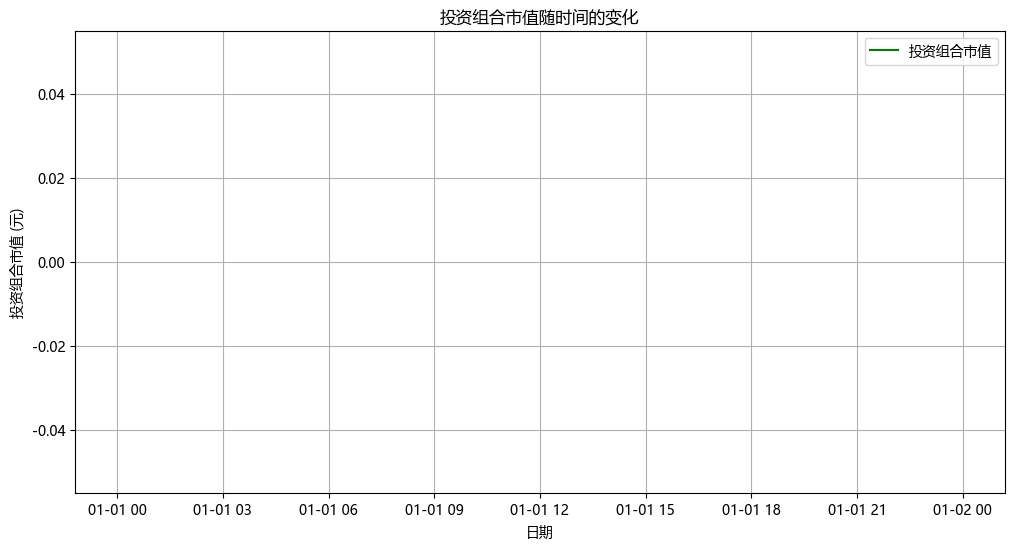

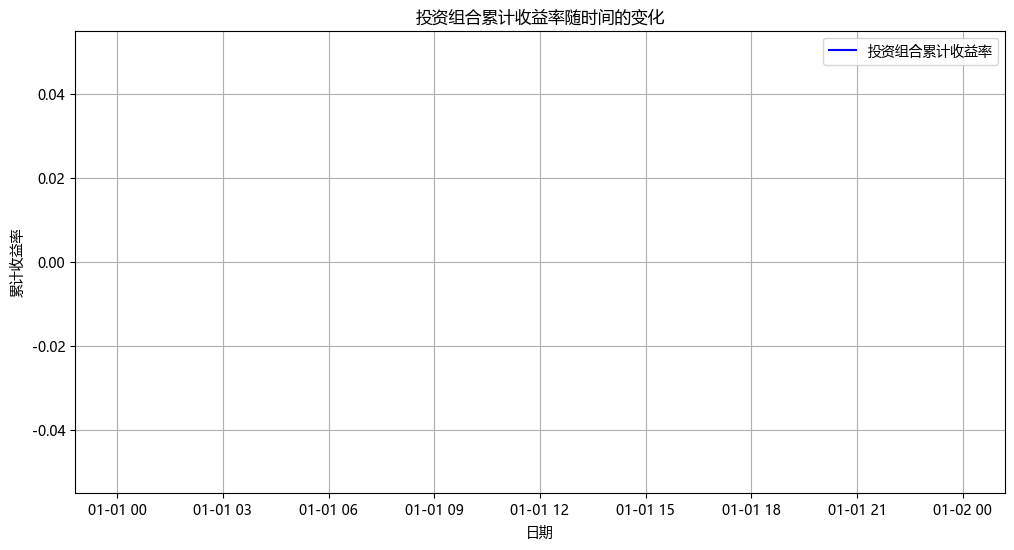

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep
from pypfopt import EfficientFrontier, expected_returns, risk_models

# 1. 读取股票价格数据
df_prices = pd.read_csv('股價.csv')

# 设置 'Date' 为索引并转换为日期类型
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.set_index('Date', inplace=True)

# 数据清洗
df_prices.dropna(how='all', inplace=True)
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
df_prices[df_prices <= 0] = np.nan

# 填充缺失值
df_prices.fillna(method='ffill', inplace=True)
df_prices.fillna(method='bfill', inplace=True)

# 将列名转换为字符串类型
df_prices.columns = df_prices.columns.astype(str)

# 2. 读取预测数据
all_predictions = pd.read_csv('predictions.csv')

# 转换数据类型
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])
all_predictions['ticker'] = all_predictions['ticker'].astype(str)

# 3. 确保预测数据起始日期正确
# 如果预测数据中有早于 2023-07-20 的日期，进行过滤
all_predictions = all_predictions[all_predictions['Date'] >= '2023-07-20']

# 设置投资组合初始资金
initial_portfolio_value = 100000000
cash = initial_portfolio_value

# 初始化持仓和投资组合价值记录
current_allocation = {}
portfolio_value_per_day = pd.DataFrame(index=df_prices.index)
portfolio_value_per_day['Total'] = np.nan

# 获取预测数据中所有周的列表
start_date = all_predictions['Date'].min()
end_date = df_prices.index.max()
weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# 定义函数
def get_top_20_stocks(predictions_df, date):
    # 获取指定日期的预测结果
    predictions_on_date = predictions_df[predictions_df['Date'] == date]
    # 如果没有预测结果，返回空列表
    if predictions_on_date.empty:
        return [], predictions_on_date
    # 按照预测回报率排序，选出前20只股票
    top_20 = predictions_on_date.sort_values(by='Predicted_Return', ascending=False).head(20)
    # 将股票代码转换为字符串
    top_20['ticker'] = top_20['ticker'].astype(str)
    return top_20['ticker'].tolist(), top_20

def adjust_portfolio(top_stocks, valid_prices, current_allocation, cash, predictions_on_date):
    # 获取历史价格数据
    historical_data = df_prices[top_stocks].loc[:rebalance_date].dropna()

    # 如果历史数据不足，使用默认的等权重
    if historical_data.shape[0] < 2:
        weights = {stock: 1/len(top_stocks) for stock in top_stocks}
    else:
        # 使用 PyPortfolioOpt 计算预期收益率和协方差矩阵
        mu = expected_returns.mean_historical_return(historical_data)
        S = risk_models.CovarianceShrinkage(historical_data).ledoit_wolf()

        try:
            # 构建有效前沿模型，计算最大夏普比率的权重
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            weights = cleaned_weights
        except Exception as e:
            print(f"优化时出错，使用等权重：{e}")
            weights = {stock: 1/len(top_stocks) for stock in top_stocks}

    # 确保权重的股票代码为字符串类型
    weights = {str(k): v for k, v in weights.items()}

    # 计算当前投资组合总价值
    total_portfolio_value = sum(current_allocation.get(stock, 0) * valid_prices.get(stock, 0) for stock in current_allocation) + cash

    # 计算目标持仓
    target_allocations = {stock: weights[stock] * total_portfolio_value for stock in top_stocks}
    target_shares = {stock: target_allocations[stock] / valid_prices[stock] for stock in top_stocks}

    # **先卖出需要卖出的股票**
    # 卖出未在新持仓中的股票
    for stock in list(current_allocation.keys()):
        if stock not in top_stocks:
            shares_to_sell = current_allocation[stock]
            price = valid_prices.get(stock, df_prices.loc[rebalance_date, stock])
            proceeds = shares_to_sell * price
            cash += proceeds
            print(f"卖出 {stock} 的 {shares_to_sell:.2f} 股，获得现金 {proceeds:.2f}")
            del current_allocation[stock]

    # 卖出需要减少的股票
    for stock in top_stocks:
        if stock in current_allocation:
            target_shares_to_hold = target_shares[stock]
            current_shares = current_allocation.get(stock, 0)
            price = valid_prices[stock]
            if current_shares > target_shares_to_hold:
                # 卖出多余的部分
                shares_to_sell = current_shares - target_shares_to_hold
                proceeds = shares_to_sell * price
                cash += proceeds
                current_allocation[stock] = target_shares_to_hold
                print(f"卖出 {stock} 的 {shares_to_sell:.2f} 股，获得现金 {proceeds:.2f}")

    # **然后买入需要买入的股票**
    for stock in top_stocks:
        target_shares_to_hold = target_shares[stock]
        current_shares = current_allocation.get(stock, 0)
        price = valid_prices[stock]
        if current_shares < target_shares_to_hold:
            # 买入缺少的部分
            shares_to_buy = target_shares_to_hold - current_shares
            cost = shares_to_buy * price
            if cost <= cash:
                cash -= cost
                current_allocation[stock] = target_shares_to_hold
                print(f"买入 {stock} 的 {shares_to_buy:.2f} 股，花费现金 {cost:.2f}")
            else:
                # 现金不足，按比例购买
                affordable_shares = cash / price
                current_allocation[stock] = current_shares + affordable_shares
                cash -= affordable_shares * price
                print(f"现金不足，调整 {stock} 的买入数量为 {affordable_shares:.2f} 股，花费现金 {affordable_shares * price:.2f}")

    return current_allocation, cash

# 主循环
for week_start in weeks:
    print(f"\n处理周开始日期：{week_start.strftime('%Y-%m-%d')}")
    week_end = week_start + pd.Timedelta(days=6)  # 一周的结束日期

    # 获取本周的开始日期
    rebalance_date = week_start

    # 获取预测回报率最高的20只股票
    top_stocks, predictions_on_date = get_top_20_stocks(all_predictions, rebalance_date)
    if not top_stocks:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 没有可用的预测结果，跳过该周。")
        continue

    # 确保 df_prices 的列名是字符串类型
    df_prices.columns = df_prices.columns.astype(str)
    # 将 top_stocks 中的股票代码转换为字符串
    top_stocks = [str(stock) for stock in top_stocks]

    # 获取本周第一个交易日的价格
    try:
        week_prices = df_prices.loc[rebalance_date:week_end, top_stocks]
        earliest_prices = week_prices.iloc[0]
    except IndexError:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 没有足够的交易日，跳过该周。")
        continue
    except KeyError as e:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 发生 KeyError：{e}")
        continue

    earliest_prices = earliest_prices.dropna()
    valid_prices = earliest_prices.to_dict()

    # 过滤掉没有价格数据的股票
    top_stocks = [stock for stock in top_stocks if stock in valid_prices]
    predictions_on_date = predictions_on_date[predictions_on_date['ticker'].isin(top_stocks)]

    if not top_stocks:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 无有效的股票可交易，跳过该周。")
        continue

    # 调整投资组合
    current_allocation, cash = adjust_portfolio(top_stocks, valid_prices, current_allocation, cash, predictions_on_date)

    # 计算每日投资组合市值
    held_stocks = list(current_allocation.keys())
    if held_stocks:
        try:
            week_prices = df_prices.loc[rebalance_date:week_end, held_stocks]
            holdings = pd.Series(current_allocation)
            daily_portfolio_value = (week_prices * holdings).sum(axis=1) + cash
            portfolio_value_per_day.loc[rebalance_date:week_end, 'Total'] = daily_portfolio_value
        except Exception as e:
            print(f"{rebalance_date.strftime('%Y-%m-%d')}: 计算每日市值时出错: {e}")

# 填充缺失的投资组合市值
portfolio_value_per_day['Total'].fillna(method='ffill', inplace=True)

# 使用 empyrical 计算绩效指标
daily_returns = portfolio_value_per_day['Total'].pct_change().dropna()
annual_return = ep.annual_return(daily_returns)
sharpe_ratio = ep.sharpe_ratio(daily_returns)
max_drawdown = ep.max_drawdown(daily_returns)

print("\n=== 绩效指标 ===")
print(f"年化收益率: {annual_return:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")

# 可视化投资组合市值随时间的变化
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_per_day.index, portfolio_value_per_day['Total'], label='投资组合市值', color='green')
plt.title('投资组合市值随时间的变化')
plt.xlabel('日期')
plt.ylabel('投资组合市值 (元)')
plt.legend()
plt.grid(True)
plt.show()

# 可视化投资组合的累计收益率
portfolio_value_per_day['Cumulative Returns'] = (1 + daily_returns).cumprod() - 1
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_per_day.index, portfolio_value_per_day['Cumulative Returns'], label='投资组合累计收益率', color='blue')
plt.title('投资组合累计收益率随时间的变化')
plt.xlabel('日期')
plt.ylabel('累计收益率')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
import shap
import warnings
import matplotlib.pyplot as plt
import empyrical as ep
from datetime import timedelta

# 忽略警告
warnings.filterwarnings('ignore')

# 设置 matplotlib 字体以显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 模型预测部分
# ---------------------------

class LightGBM:
    @staticmethod
    def lgbm_feature_importance(train_X, train_Y, params, importance_type='gain', isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier(**params)
            else:
                model = lgb.LGBMRegressor(**params)
            
            model.fit(train_X, train_Y)
            
            # 获取特征重要性
            importance_values = model.feature_importance(importance_type=importance_type)
            feature_names = train_X.columns
            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            
            return feature_importance_df, model
        except Exception as e:
            print('lgbm_feature_importance has error: ' + str(e))
            return None, None

    @staticmethod
    def grid_tune(train_X, train_Y, fold_time, isClassifier=True, param_grid=None):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            grid_search = GridSearchCV(estimator=model,
                                       param_grid=param_grid,
                                       cv=tscv,
                                       n_jobs=-1,
                                       scoring=scoring,
                                       verbose=1)
            grid_search.fit(train_X, train_Y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('grid_tune has error: ' + str(e))
            return None, None, None

    @staticmethod
    def random_tune(train_X, train_Y, fold_time, isClassifier=True, param_distributions=None, n_iter=10):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            random_search = RandomizedSearchCV(estimator=model,
                                               param_distributions=param_distributions,
                                               cv=tscv,
                                               n_jobs=-1,
                                               scoring=scoring,
                                               n_iter=n_iter,
                                               verbose=1,
                                               random_state=42)
            random_search.fit(train_X, train_Y)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_results = pd.DataFrame(random_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('random_tune has error: ' + str(e))
            return None, None, None

# 读取数据
df = pd.read_csv('合併資料.csv')

# 将 'Date' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 确保数据按照 'ticker' 和 'Date' 排序
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# 定义目标变量和特征
target = 'Daily_Return'  # 请替换为您的目标变量名称
features = [col for col in df.columns if col not in ['Date', 'ticker', target]]

def train_and_predict_single_ticker(group_df):
    # 确保数据按照日期排序
    group_df = group_df.sort_values('Date').reset_index(drop=True)
    
    # 如果数据量太少，无法训练，则跳过
    if len(group_df) < 20:
        print(f"Ticker {group_df['ticker'].iloc[0]} 数据量不足，跳过")
        return None
    
    # 使用前 80% 的数据作为训练集，后 20% 的数据作为测试集
    split_index = int(len(group_df) * 0.8)
    train = group_df.iloc[:split_index]
    test = group_df.iloc[split_index:]
    
    if len(test) == 0 or len(train) == 0:
        print(f"Ticker {group_df['ticker'].iloc[0]} 训练集或测试集为空，跳过")
        return None
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # 模型参数
    params = {
        'boosting_type': 'gbdt',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'random_state': 7,
        'verbose': 0,
        'min_data_in_leaf': 5,
        'lambda_l1': 0.1,  # L1 正则化
        'lambda_l2': 0.1   # L2 正则化
    }
    
    # 使用 LightGBM 内置特征重要性进行特征选择
    try:
        feature_importance_df, model = LightGBM.lgbm_feature_importance(X_train, y_train, params, importance_type='gain', isClassifier=False)
        if feature_importance_df is not None:
            # 设置特征重要性阈值，选择前 20% 重要性的特征
            threshold = feature_importance_df['Importance'].quantile(0.5)
            important_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()
            # 输出特征重要性
            print(f"Ticker {group_df['ticker'].iloc[0]} 的特征重要性：")
            print(feature_importance_df)
            print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征数量：{len(important_features)}")
            print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征：{important_features}")
        else:
            important_features = features  # 如果获取特征重要性失败，使用所有特征
    except Exception as e:
        print(f'Error during LightGBM feature importance analysis for ticker {group_df["ticker"].iloc[0]}: {str(e)}')
        important_features = features
        model = None
    
    # 记录重要特征
    selected_features = important_features.copy()
    
    # 使用重要特征进行模型训练（未调参数）
    X_train_important = X_train[selected_features]
    X_test_important = X_test[selected_features]
    
    # 如果之前没有训练模型，则重新训练
    if model is None:
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_important, y_train)
    
    # 计算训练集 MAE（原始模型）
    y_pred_train = model.predict(X_train_important)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 训练集 MAE: {mae_train}")
    
    # 计算测试集 MAE（原始模型）
    y_pred_test = model.predict(X_test_important)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 测试集 MAE: {mae_test}")
    
    # 参数调优 - 网格搜索
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }
    
    best_model_grid, best_params_grid, cv_results_grid = LightGBM.grid_tune(
        X_train_important, y_train, fold_time=5, param_grid=param_grid, isClassifier=False
    )
    
    if best_model_grid is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 最佳参数: {best_params_grid}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_grid = best_model_grid.predict(X_train_important)
        mae_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_grid = best_model_grid.predict(X_test_important)
        mae_test_grid = mean_absolute_error(y_test, y_pred_test_grid)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 训练集 MAE: {mae_train_grid}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 测试集 MAE: {mae_test_grid}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_grid = model
        mae_train_grid = mae_train
        mae_test_grid = mae_test
    
    # 参数调优 - 随机搜索
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }
    
    best_model_random, best_params_random, cv_results_random = LightGBM.random_tune(
        X_train_important, y_train, fold_time=5, param_distributions=param_dist, isClassifier=False, n_iter=10
    )
    
    if best_model_random is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 最佳参数: {best_params_random}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_random = best_model_random.predict(X_train_important)
        mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_random = best_model_random.predict(X_test_important)
        mae_test_random = mean_absolute_error(y_test, y_pred_test_random)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 训练集 MAE: {mae_train_random}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 测试集 MAE: {mae_test_random}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_random = model
        mae_train_random = mae_train
        mae_test_random = mae_test
    
    # 计算 SHAP 值（使用最佳模型之一，这里以 Grid Search 调优后的模型为例）
    try:
        explainer = shap.TreeExplainer(best_model_grid)
        shap_values = explainer.shap_values(X_train_important)
    except Exception as e:
        print(f"Error during SHAP calculation for ticker {group_df['ticker'].iloc[0]}: {str(e)}")
        shap_values = None
    
    # 构建结果字典
    result_dict = {
        'ticker': group_df['ticker'].iloc[0],
        'selected_features': selected_features,
        'original_train_mae': mae_train,
        'original_test_mae': mae_test,
        'grid_train_mae': mae_train_grid,
        'grid_test_mae': mae_test_grid,
        'random_train_mae': mae_train_random,
        'random_test_mae': mae_test_random,
        'original_model': model,
        'best_model_grid': best_model_grid,
        'best_model_random': best_model_random,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'test_dates': test['Date'].values,
        'shap_values': shap_values,
        'shap_feature_names': X_train_important.columns.tolist(),
        'X_train_important': X_train_important,
        'best_params_grid': best_params_grid,
        'best_params_random': best_params_random,
        'cv_results_grid': cv_results_grid,
        'cv_results_random': cv_results_random
    }
    
    # 将预测结果保存到结果字典中
    test_dates = test['Date'].values
    predictions = pd.DataFrame({
        'Date': test_dates,
        'ticker': group_df['ticker'].iloc[0],
        'Predicted_Return': y_pred_test
    })
    result_dict['predictions'] = predictions
    
    return result_dict

# 初始化结果列表
results = []

# 按照 'ticker' 分组
grouped = df.groupby('ticker')

for name, group in grouped:
    print(f"\n正在处理 Ticker: {name}")
    result = train_and_predict_single_ticker(group)
    if result is not None:
        results.append(result)

# 将所有预测结果合并
all_predictions = pd.concat([res['predictions'] for res in results], ignore_index=True)

# 确保日期格式正确
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

# 保存预测结果为 CSV 文件（可选）
all_predictions.to_csv('predictions.csv', index=False)

# 绘制 SHAP 图
shap.initjs()

for res in results:
    ticker = res['ticker']
    shap_values = res['shap_values']
    feature_names = res['shap_feature_names']
    X_train_important = res['X_train_important']

    if shap_values is not None:
        print(f"绘制 Ticker {ticker} 的 SHAP 图")
    
        # 绘制 SHAP summary plot
        shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, show=False)
        plt.title(f"Ticker {ticker} - SHAP Summary Plot")
        plt.savefig(f'shap_summary_{ticker}.png', dpi=300)
        plt.close()
    
        # 绘制 SHAP bar plot
        shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"Ticker {ticker} - SHAP Feature Importance")
        plt.savefig(f'shap_bar_{ticker}.png', dpi=300)
        plt.close()
    else:
        print(f"Ticker {ticker} 的 SHAP 值计算失败，无法绘制 SHAP 图")

# 输出每个 ticker 的 MAE
for res in results:
    ticker = res['ticker']
    print(f"\n=== {ticker} 的模型性能 ===")
    print(f"原始模型训练集 MAE: {res['original_train_mae']}")
    print(f"原始模型测试集 MAE: {res['original_test_mae']}")
    print(f"Grid Search 调优模型训练集 MAE: {res['grid_train_mae']}")
    print(f"Grid Search 调优模型测试集 MAE: {res['grid_test_mae']}")
    print(f"Random Search 调优模型训练集 MAE: {res['random_train_mae']}")
    print(f"Random Search 调优模型测试集 MAE: {res['random_test_mae']}")

# 计算所有 ticker 的平均训练集 MAE 和平均测试集 MAE
train_maes = [res['original_train_mae'] for res in results]
test_maes = [res['original_test_mae'] for res in results]

avg_train_mae = np.mean(train_maes)
avg_test_mae = np.mean(test_maes)

print("\n=== 模型整体性能评估 ===")
print(f"平均训练集 MAE: {avg_train_mae}")
print(f"平均测试集 MAE: {avg_test_mae}")

# ---------------------------
# 投资组合构建和绩效评估部分
# ---------------------------
# ...（此部分代码保持不变）



正在处理 Ticker: 1101
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

KeyboardInterrupt: 

In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
import shap
import warnings
import matplotlib.pyplot as plt
import empyrical as ep
from datetime import timedelta

# 忽略警告
warnings.filterwarnings('ignore')

# 设置 matplotlib 字体以显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 模型预测部分
# ---------------------------

class LightGBM:
    @staticmethod
    def shap_feature_importance(train_X, train_Y, params, isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier(**params)
            else:
                model = lgb.LGBMRegressor(**params)
            
            model.fit(train_X, train_Y)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(train_X)
            
            # 计算特征重要性
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': mean_abs_shap})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            
            return feature_importance_df, shap_values, model
        except Exception as e:
            print('shap_feature_importance has error: ' + str(e))
            return None, None, None

    @staticmethod
    def grid_tune(train_X, train_Y, fold_time, isClassifier=True, param_grid=None):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            grid_search = GridSearchCV(estimator=model,
                                       param_grid=param_grid,
                                       cv=tscv,
                                       n_jobs=-1,
                                       scoring=scoring,
                                       verbose=1)
            grid_search.fit(train_X, train_Y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('grid_tune has error: ' + str(e))
            return None, None, None

    @staticmethod
    def random_tune(train_X, train_Y, fold_time, isClassifier=True, param_distributions=None, n_iter=10):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'
            
            tscv = TimeSeriesSplit(n_splits=fold_time)

            random_search = RandomizedSearchCV(estimator=model,
                                               param_distributions=param_distributions,
                                               cv=tscv,
                                               n_jobs=-1,
                                               scoring=scoring,
                                               n_iter=n_iter,
                                               verbose=1,
                                               random_state=42)
            random_search.fit(train_X, train_Y)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_results = pd.DataFrame(random_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('random_tune has error: ' + str(e))
            return None, None, None

# 读取数据
df = pd.read_csv('合併資料.csv')

# 将 'Date' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 确保数据按照 'ticker' 和 'Date' 排序
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# 定义目标变量和特征
target = 'Daily_Return'  # 请替换为您的目标变量名称
features = [col for col in df.columns if col not in ['Date', 'ticker', target]]

def train_and_predict_single_ticker(group_df, shap_threshold=0.9):
    # 确保数据按照日期排序
    group_df = group_df.sort_values('Date').reset_index(drop=True)
    
    # 如果数据量太少，无法训练，则跳过
    if len(group_df) < 20:
        print(f"Ticker {group_df['ticker'].iloc[0]} 数据量不足，跳过")
        return None
    
    # 使用前 80% 的数据作为训练集，后 20% 的数据作为测试集
    split_index = int(len(group_df) * 0.8)
    train = group_df.iloc[:split_index]
    test = group_df.iloc[split_index:]
    
    if len(test) == 0:
        print(f"Ticker {group_df['ticker'].iloc[0]} 测试集为空，跳过")
        return None
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # 模型参数
    params = {
        'boosting_type': 'dart',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'random_state': 7,
        'verbose': 0,
    }
    
    # 使用 SHAP 进行特征重要性分析
    try:
        feature_importance_df, shap_values, initial_model = LightGBM.shap_feature_importance(
            X_train, y_train, params=params, isClassifier=False)
        if feature_importance_df is not None:
            # 计算累计贡献度
            total_importance = feature_importance_df['Importance'].sum()
            feature_importance_df['Cumulative'] = feature_importance_df['Importance'].cumsum() / total_importance
            # 根据阈值选择特征
            important_features = feature_importance_df[feature_importance_df['Cumulative'] <= shap_threshold]['Feature'].tolist()
            print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征数量：{len(important_features)}")
            print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征：{important_features}")
        else:
            important_features = features  # 如果 SHAP 分析失败，使用所有特征
    except Exception as e:
        print(f'Error during SHAP feature importance analysis for ticker {group_df["ticker"].iloc[0]}: {str(e)}')
        important_features = features
        shap_values = None
        initial_model = None
    
    # 记录重要特征
    selected_features = important_features.copy()
    
    # 使用重要特征进行模型训练（未调参数）
    X_train_important = X_train[selected_features]
    X_test_important = X_test[selected_features]
    
    # 重新训练模型
    original_model = lgb.LGBMRegressor(**params)
    original_model.fit(X_train_important, y_train)
    
    # 重新计算 SHAP 值
    explainer = shap.TreeExplainer(original_model)
    shap_values = explainer.shap_values(X_train_important)
    
    # 计算训练集 MAE（原始模型）
    y_pred_train = original_model.predict(X_train_important)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的训练集 MAE: {mae_train}")
    
    # 计算测试集 MAE（原始模型）
    y_pred_original = original_model.predict(X_test_important)
    mae_original = mean_absolute_error(y_test, y_pred_original)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的测试集 MAE: {mae_original}")
    
    # 参数调优 - 网格搜索
    param_grid = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9, -1],
    'num_leaves': [15, 31, 63, 127],
    'n_estimators': [50, 100, 200, 500],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda_l1': [0, 0.01, 0.1, 1],
    'lambda_l2': [0, 0.01, 0.1, 1],
    'boosting_type': ['gbdt', 'dart'],
    'random_state': [7],
}
    
    best_model_grid, best_params_grid, cv_results_grid = LightGBM.grid_tune(
        X_train_important, y_train, fold_time=5, param_grid=param_grid, isClassifier=False)
    
    if best_model_grid is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 最佳参数: {best_params_grid}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_grid = best_model_grid.predict(X_train_important)
        mae_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_grid = best_model_grid.predict(X_test_important)
        mae_test_grid = mean_absolute_error(y_test, y_pred_test_grid)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 训练集 MAE: {mae_train_grid}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 测试集 MAE: {mae_test_grid}")
        
        # 获取调优后模型的特征重要性
        explainer_grid = shap.TreeExplainer(best_model_grid)
        shap_values_grid = explainer_grid.shap_values(X_train_important)
        # 计算特征重要性
        mean_abs_shap_grid = np.abs(shap_values_grid).mean(axis=0)
        feature_importance_grid = pd.DataFrame({'Feature': X_train_important.columns, 'Importance': mean_abs_shap_grid})
        feature_importance_grid = feature_importance_grid.sort_values(by='Importance', ascending=False)
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_grid = original_model
        mae_train_grid = mae_train
        mae_test_grid = mae_original
        feature_importance_grid = None
    
    # 参数调优 - 随机搜索
    param_dist = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9, -1],
    'num_leaves': [15, 31, 63, 127],
    'n_estimators': [50, 100, 200, 500],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda_l1': [0, 0.01, 0.1, 1],
    'lambda_l2': [0, 0.01, 0.1, 1],
    'boosting_type': ['gbdt', 'dart'],
    'random_state': [7],
}
    
    best_model_random, best_params_random, cv_results_random = LightGBM.random_tune(
        X_train_important, y_train, fold_time=5, param_distributions=param_dist, isClassifier=False, n_iter=10)
    
    if best_model_random is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 最佳参数: {best_params_random}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_random = best_model_random.predict(X_train_important)
        mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_random = best_model_random.predict(X_test_important)
        mae_test_random = mean_absolute_error(y_test, y_pred_test_random)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 训练集 MAE: {mae_train_random}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 测试集 MAE: {mae_test_random}")
        
        # 获取调优后模型的特征重要性
        explainer_random = shap.TreeExplainer(best_model_random)
        shap_values_random = explainer_random.shap_values(X_train_important)
        # 计算特征重要性
        mean_abs_shap_random = np.abs(shap_values_random).mean(axis=0)
        feature_importance_random = pd.DataFrame({'Feature': X_train_important.columns, 'Importance': mean_abs_shap_random})
        feature_importance_random = feature_importance_random.sort_values(by='Importance', ascending=False)
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_random = original_model
        mae_train_random = mae_train
        mae_test_random = mae_original
        feature_importance_random = None
    
    # 构建结果字典
    result_dict = {
        'ticker': group_df['ticker'].iloc[0],
        'selected_features': selected_features,
        'original_train_mae': mae_train,
        'original_test_mae': mae_original,
        'grid_train_mae': mae_train_grid,
        'grid_test_mae': mae_test_grid,
        'random_train_mae': mae_train_random,
        'random_test_mae': mae_test_random,
        'original_model': original_model,
        'best_model_grid': best_model_grid,
        'best_model_random': best_model_random,
        'y_test': y_test,
        'y_pred_test': y_pred_original,
        'test_dates': test['Date'].values,
        'shap_values': shap_values,
        'shap_feature_names': X_train_important.columns.tolist(),
        'X_train_important': X_train_important,
        'best_params_grid': best_params_grid,
        'best_params_random': best_params_random,
        'cv_results_grid': cv_results_grid,
        'cv_results_random': cv_results_random,
        'feature_importance_grid': feature_importance_grid,
        'feature_importance_random': feature_importance_random
    }
    
    # 将预测结果保存到结果字典中
    predictions = pd.DataFrame({
        'Date': test['Date'].values,
        'ticker': group_df['ticker'].iloc[0],
        'Predicted_Return': y_pred_original
    })
    result_dict['predictions'] = predictions
    
    return result_dict

# 初始化结果列表
results = []

# 按照 'ticker' 分组
grouped = df.groupby('ticker')

for name, group in grouped:
    print(f"\n正在处理 Ticker: {name}")
    result = train_and_predict_single_ticker(group, shap_threshold=0.85)  # 您可以更改 shap_threshold 的值
    if result is not None:
        results.append(result)

# 将所有预测结果合并
all_predictions = pd.concat([res['predictions'] for res in results], ignore_index=True)

# 确保日期格式正确
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

# 保存预测结果为 CSV 文件（可选）
all_predictions.to_csv('predictions.csv', index=False)

# 绘制 SHAP 图
shap.initjs()

for res in results:
    ticker = res['ticker']
    shap_values = res['shap_values']
    feature_names = res['shap_feature_names']
    X_train_important = res['X_train_important']

    print(f"绘制 Ticker {ticker} 的 SHAP 图")

    # 绘制 SHAP summary plot
    shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, show=False)
    plt.title(f"Ticker {ticker} - SHAP Summary Plot")
    plt.savefig(f'shap_summary_{ticker}.png', dpi=300)
    plt.close()

    # 绘制 SHAP bar plot
    shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"Ticker {ticker} - SHAP Feature Importance")
    plt.savefig(f'shap_bar_{ticker}.png', dpi=300)
    plt.close()
    
    # 绘制参数调优后模型的 SHAP 图（可选）
    if res['feature_importance_grid'] is not None:
        print(f"绘制 Ticker {ticker} - Grid Search 调优后模型的特征重要性")
        res['feature_importance_grid'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Grid Search Model Feature Importance")
        plt.savefig(f'feature_importance_grid_{ticker}.png', dpi=300)
        plt.close()
    
    if res['feature_importance_random'] is not None:
        print(f"绘制 Ticker {ticker} - Random Search 调优后模型的特征重要性")
        res['feature_importance_random'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Random Search Model Feature Importance")
        plt.savefig(f'feature_importance_random_{ticker}.png', dpi=300)
        plt.close()

# 输出每个 ticker 的 MAE
for res in results:
    ticker = res['ticker']
    print(f"\n=== {ticker} 的模型性能 ===")
    print(f"原始模型训练集 MAE: {res['original_train_mae']}")
    print(f"原始模型测试集 MAE: {res['original_test_mae']}")
    print(f"Grid Search 调优模型训练集 MAE: {res['grid_train_mae']}")
    print(f"Grid Search 调优模型测试集 MAE: {res['grid_test_mae']}")
    print(f"Random Search 调优模型训练集 MAE: {res['random_train_mae']}")
    print(f"Random Search 调优模型测试集 MAE: {res['random_test_mae']}")

# ---------------------------
# 投资组合构建和绩效评估部分
# ---------------------------
# ...（此部分代码保持不变）



正在处理 Ticker: 1101
Ticker 1101 - 选择的特征数量：7
Ticker 1101 - 选择的特征：['HL1M', 'PM5D', 'PM1M', 'AnnVol1M', 'Chg1YAstTo', '90DCV', 'BP']
Ticker 1101 - 原始模型的训练集 MAE: 0.005768991764547503
Ticker 1101 - 原始模型的测试集 MAE: 0.006058010294683972
Fitting 5 folds for each of 368640 candidates, totalling 1843200 fits


KeyboardInterrupt: 

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
import shap
import warnings
import matplotlib.pyplot as plt
import empyrical as ep
from datetime import timedelta

# 忽略警告
warnings.filterwarnings('ignore')

# 设置 matplotlib 字体以显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 模型预测部分
# ---------------------------

class LightGBM:
    @staticmethod
    def shap_feature_importance(train_X, train_Y, params, isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier(**params)
            else:
                model = lgb.LGBMRegressor(**params)

            model.fit(train_X, train_Y)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(train_X)

            # 计算特征重要性
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': mean_abs_shap})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            return feature_importance_df, shap_values, model
        except Exception as e:
            print('shap_feature_importance has error: ' + str(e))
            return None, None, None

    @staticmethod
    def grid_tune(train_X, train_Y, fold_time, isClassifier=True, param_grid=None):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'

            tscv = TimeSeriesSplit(n_splits=fold_time)

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                n_jobs=-1,
                scoring=scoring,
                verbose=1
            )
            grid_search.fit(train_X, train_Y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('grid_tune has error: ' + str(e))
            return None, None, None

    @staticmethod
    def random_tune(train_X, train_Y, fold_time, isClassifier=True, param_distributions=None, n_iter=10):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'

            tscv = TimeSeriesSplit(n_splits=fold_time)

            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_distributions,
                cv=tscv,
                n_jobs=-1,
                scoring=scoring,
                n_iter=n_iter,
                verbose=1,
                random_state=42
            )
            random_search.fit(train_X, train_Y)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_results = pd.DataFrame(random_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('random_tune has error: ' + str(e))
            return None, None, None

# 读取数据
df = pd.read_csv('合併資料.csv')

# 将 'Date' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 确保数据按照 'ticker' 和 'Date' 排序
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# 定义目标变量和特征
target = 'Daily_Return'  # 请替换为您的目标变量名称
features = [col for col in df.columns if col not in ['Date', 'ticker', target]]

def train_and_predict_single_ticker(group_df, shap_threshold=0.85, use_feature_selection=True):
    # 确保数据按照日期排序
    group_df = group_df.sort_values('Date').reset_index(drop=True)

    # 如果数据量太少，无法训练，则跳过
    if len(group_df) < 20:
        print(f"Ticker {group_df['ticker'].iloc[0]} 数据量不足，跳过")
        return None

    # 使用前 80% 的数据作为训练集，后 20% 的数据作为测试集
    split_index = int(len(group_df) * 0.8)
    train = group_df.iloc[:split_index]
    test = group_df.iloc[split_index:]

    if len(test) == 0:
        print(f"Ticker {group_df['ticker'].iloc[0]} 测试集为空，跳过")
        return None

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # 模型参数
    params = {
        'boosting_type': 'dart',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'random_state': 7,
        'verbose': 0,
    }

    if use_feature_selection:
        # 使用 SHAP 进行特征重要性分析
        try:
            feature_importance_df, shap_values, initial_model = LightGBM.shap_feature_importance(
                X_train, y_train, params=params, isClassifier=False)
            if feature_importance_df is not None:
                # 计算累计贡献度
                total_importance = feature_importance_df['Importance'].sum()
                feature_importance_df['Cumulative'] = feature_importance_df['Importance'].cumsum() / total_importance
                # 根据阈值选择特征
                important_features = feature_importance_df[feature_importance_df['Cumulative'] <= shap_threshold]['Feature'].tolist()
                print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征数量：{len(important_features)}")
                print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征：{important_features}")
            else:
                important_features = features  # 如果 SHAP 分析失败，使用所有特征
        except Exception as e:
            print(f'Error during SHAP feature importance analysis for ticker {group_df["ticker"].iloc[0]}: {str(e)}')
            important_features = features
            shap_values = None
            initial_model = None
    else:
        # 不进行特征选择，使用所有特征
        important_features = features
        shap_values = None
        initial_model = None

    # 记录重要特征
    selected_features = important_features.copy()

    # 使用重要特征进行模型训练（未调参数）
    X_train_important = X_train[selected_features]
    X_test_important = X_test[selected_features]

    # 重新训练模型
    original_model = lgb.LGBMRegressor(**params)
    original_model.fit(X_train_important, y_train)

    # 重新计算 SHAP 值
    if use_feature_selection:
        explainer = shap.TreeExplainer(original_model)
        shap_values = explainer.shap_values(X_train_important)

    # 计算训练集 MAE（原始模型）
    y_pred_train = original_model.predict(X_train_important)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的训练集 MAE: {mae_train}")

    # 计算测试集 MAE（原始模型）
    y_pred_original = original_model.predict(X_test_important)
    mae_original = mean_absolute_error(y_test, y_pred_original)
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型的测试集 MAE: {mae_original}")

    # 参数调优 - 网格搜索
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }

    best_model_grid, best_params_grid, cv_results_grid = LightGBM.grid_tune(
        X_train_important, y_train, fold_time=5, param_grid=param_grid, isClassifier=False)

    if best_model_grid is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 最佳参数: {best_params_grid}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_grid = best_model_grid.predict(X_train_important)
        mae_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_grid = best_model_grid.predict(X_test_important)
        mae_test_grid = mean_absolute_error(y_test, y_pred_test_grid)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 训练集 MAE: {mae_train_grid}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 测试集 MAE: {mae_test_grid}")

        # 获取调优后模型的特征重要性
        explainer_grid = shap.TreeExplainer(best_model_grid)
        shap_values_grid = explainer_grid.shap_values(X_train_important)
        # 计算特征重要性
        mean_abs_shap_grid = np.abs(shap_values_grid).mean(axis=0)
        feature_importance_grid = pd.DataFrame({'Feature': X_train_important.columns, 'Importance': mean_abs_shap_grid})
        feature_importance_grid = feature_importance_grid.sort_values(by='Importance', ascending=False)
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_grid = original_model
        mae_train_grid = mae_train
        mae_test_grid = mae_original
        feature_importance_grid = None

    # 参数调优 - 随机搜索
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }

    best_model_random, best_params_random, cv_results_random = LightGBM.random_tune(
        X_train_important, y_train, fold_time=5, param_distributions=param_dist, isClassifier=False, n_iter=20)

    if best_model_random is not None:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 最佳参数: {best_params_random}")
        # 计算训练集 MAE（调优后模型）
        y_pred_train_random = best_model_random.predict(X_train_important)
        mae_train_random = mean_absolute_error(y_train, y_pred_train_random)
        # 计算测试集 MAE（调优后模型）
        y_pred_test_random = best_model_random.predict(X_test_important)
        mae_test_random = mean_absolute_error(y_test, y_pred_test_random)
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 训练集 MAE: {mae_train_random}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 测试集 MAE: {mae_test_random}")

        # 获取调优后模型的特征重要性
        explainer_random = shap.TreeExplainer(best_model_random)
        shap_values_random = explainer_random.shap_values(X_train_important)
        # 计算特征重要性
        mean_abs_shap_random = np.abs(shap_values_random).mean(axis=0)
        feature_importance_random = pd.DataFrame({'Feature': X_train_important.columns, 'Importance': mean_abs_shap_random})
        feature_importance_random = feature_importance_random.sort_values(by='Importance', ascending=False)
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 未找到最佳模型，使用默认参数训练模型。")
        best_model_random = original_model
        mae_train_random = mae_train
        mae_test_random = mae_original
        feature_importance_random = None

    # 构建结果字典
    result_dict = {
        'ticker': group_df['ticker'].iloc[0],
        'selected_features': selected_features,
        'original_train_mae': mae_train,
        'original_test_mae': mae_original,
        'grid_train_mae': mae_train_grid,
        'grid_test_mae': mae_test_grid,
        'random_train_mae': mae_train_random,
        'random_test_mae': mae_test_random,
        'original_model': original_model,
        'best_model_grid': best_model_grid,
        'best_model_random': best_model_random,
        'y_test': y_test,
        'y_pred_test': y_pred_original,
        'test_dates': test['Date'].values,
        'shap_values': shap_values,
        'shap_feature_names': X_train_important.columns.tolist(),
        'X_train_important': X_train_important,
        'best_params_grid': best_params_grid,
        'best_params_random': best_params_random,
        'cv_results_grid': cv_results_grid,
        'cv_results_random': cv_results_random,
        'feature_importance_grid': feature_importance_grid,
        'feature_importance_random': feature_importance_random
    }

    # 将预测结果保存到结果字典中，包括实际值和预测值
    predictions = pd.DataFrame({
        'Date': test['Date'].values,
        'ticker': group_df['ticker'].iloc[0],
        'Actual_Return': y_test.values,           # 添加实际值
        'Predicted_Return': y_pred_original        # 添加预测值
    })
    result_dict['predictions'] = predictions

    return result_dict

# 初始化结果列表
results = []

# 按照 'ticker' 分组
grouped = df.groupby('ticker')

for name, group in grouped:
    print(f"\n正在处理 Ticker: {name}")
    result = train_and_predict_single_ticker(
        group,
        shap_threshold=0.85,       # 您可以更改 shap_threshold 的值
        use_feature_selection=False  # 设置为 True，进行特征选择
    )
    if result is not None:
        results.append(result)

# 将所有预测结果合并
all_predictions = pd.concat([res['predictions'] for res in results], ignore_index=True)

# 确保日期格式正确
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

# 保存预测结果为 CSV 文件（可选）
all_predictions.to_csv('predictions.csv', index=False)

# 绘制 SHAP 图
shap.initjs()

for res in results:
    ticker = res['ticker']
    shap_values = res['shap_values']
    feature_names = res['shap_feature_names']
    X_train_important = res['X_train_important']

    print(f"绘制 Ticker {ticker} 的 SHAP 图")

    # 绘制 SHAP summary plot
    if shap_values is not None:
        shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, show=False)
        plt.title(f"Ticker {ticker} - SHAP Summary Plot")
        plt.savefig(f'shap_summary_{ticker}.png', dpi=300)
        plt.close()

        # 绘制 SHAP bar plot
        shap.summary_plot(shap_values, X_train_important, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"Ticker {ticker} - SHAP Feature Importance")
        plt.savefig(f'shap_bar_{ticker}.png', dpi=300)
        plt.close()
    else:
        print(f"Ticker {ticker} 的 SHAP 值计算失败，无法绘制 SHAP 图")

    # 绘制参数调优后模型的特征重要性图（如果存在）
    if res['feature_importance_grid'] is not None:
        plt.figure(figsize=(10, 6))
        res['feature_importance_grid'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Grid Search Model Feature Importance")
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_grid_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Grid Search Model Feature Importance 图为 'feature_importance_grid_{ticker}.png'")

    if res['feature_importance_random'] is not None:
        plt.figure(figsize=(10, 6))
        res['feature_importance_random'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Random Search Model Feature Importance")
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_random_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Random Search Model Feature Importance 图为 'feature_importance_random_{ticker}.png'")

    # 绘制预测值与真实值的比较图
    predictions = res['predictions']
    if predictions is not None and not predictions.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(predictions['Date'], predictions['Actual_Return'], label='Actual Return', marker='o')
        plt.plot(predictions['Date'], predictions['Predicted_Return'], label='Predicted Return', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title(f'Ticker {ticker} - Actual vs Predicted Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'actual_vs_predicted_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Actual vs Predicted Returns 图为 'actual_vs_predicted_{ticker}.png'")
    else:
        print(f"Ticker {ticker} 没有足够的数据绘制 Actual vs Predicted Returns 图")

# 输出每个 ticker 的 MAE
for res in results:
    ticker = res['ticker']
    print(f"\n=== {ticker} 的模型性能 ===")
    print(f"原始模型训练集 MAE: {res['original_train_mae']}")
    print(f"原始模型测试集 MAE: {res['original_test_mae']}")
    print(f"Grid Search 调优模型训练集 MAE: {res['grid_train_mae']}")
    print(f"Grid Search 调优模型测试集 MAE: {res['grid_test_mae']}")
    print(f"Random Search 调优模型训练集 MAE: {res['random_train_mae']}")
    print(f"Random Search 调优模型测试集 MAE: {res['random_test_mae']}")

# ---------------------------
# 投资组合构建和绩效评估部分
# ---------------------------
# ...（此部分代码保持不变）



正在处理 Ticker: 1101
Ticker 1101 - 原始模型的训练集 MAE: 0.005730106883920632
Ticker 1101 - 原始模型的测试集 MAE: 0.006029974203810676
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

绘制 Ticker 1101 的 SHAP 图
Ticker 1101 的 SHAP 值计算失败，无法绘制 SHAP 图
保存 Ticker 1101 的 Grid Search Model Feature Importance 图为 'feature_importance_grid_1101.png'
保存 Ticker 1101 的 Random Search Model Feature Importance 图为 'feature_importance_random_1101.png'
保存 Ticker 1101 的 Actual vs Predicted Returns 图为 'actual_vs_predicted_1101.png'
绘制 Ticker 1216 的 SHAP 图
Ticker 1216 的 SHAP 值计算失败，无法绘制 SHAP 图
保存 Ticker 1216 的 Grid Search Model Feature Importance 图为 'feature_importance_grid_1216.png'
保存 Ticker 1216 的 Random Search Model Feature Importance 图为 'feature_importance_random_1216.png'
保存 Ticker 1216 的 Actual vs Predicted Returns 图为 'actual_vs_predicted_1216.png'
绘制 Ticker 1301 的 SHAP 图
Ticker 1301 的 SHAP 值计算失败，无法绘制 SHAP 图
保存 Ticker 1301 的 Grid Search Model Feature Importance 图为 'feature_importance_grid_1301.png'
保存 Ticker 1301 的 Random Search Model Feature Importance 图为 'feature_importance_random_1301.png'
保存 Ticker 1301 的 Actual vs Predicted Returns 图为 'actual_vs_predicted_1301.png'
绘制 Ticker 1303 的

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
import shap
import warnings
import matplotlib.pyplot as plt
from datetime import timedelta

# 忽略警告
warnings.filterwarnings('ignore')

# 设置 matplotlib 字体以显示中文
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------
# 模型预测部分
# ---------------------------

class LightGBMModel:
    @staticmethod
    def shap_feature_importance(train_X, train_Y, params, isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier(**params)
            else:
                model = lgb.LGBMRegressor(**params)

            model.fit(train_X, train_Y)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(train_X)

            # 计算特征重要性
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': mean_abs_shap})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            return feature_importance_df, shap_values, model
        except Exception as e:
            print('shap_feature_importance has error: ' + str(e))
            return None, None, None

    @staticmethod
    def grid_tune(train_X, train_Y, fold_time, param_grid, isClassifier=True):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'

            tscv = TimeSeriesSplit(n_splits=fold_time)

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                n_jobs=-1,
                scoring=scoring,
                verbose=1
            )
            grid_search.fit(train_X, train_Y)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('grid_tune has error: ' + str(e))
            return None, None, None

    @staticmethod
    def random_tune(train_X, train_Y, fold_time, param_distributions, isClassifier=True, n_iter=10):
        try:
            if isClassifier:
                model = lgb.LGBMClassifier()
                scoring = 'accuracy'
            else:
                model = lgb.LGBMRegressor()
                scoring = 'neg_mean_absolute_error'

            tscv = TimeSeriesSplit(n_splits=fold_time)

            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_distributions,
                cv=tscv,
                n_jobs=-1,
                scoring=scoring,
                n_iter=n_iter,
                verbose=1,
                random_state=42
            )
            random_search.fit(train_X, train_Y)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_results = pd.DataFrame(random_search.cv_results_)
            return best_model, best_params, cv_results
        except Exception as e:
            print('random_tune has error: ' + str(e))
            return None, None, None

# 读取数据
df = pd.read_csv('合併資料.csv')

# 将 'Date' 列转换为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 确保数据按照 'ticker' 和 'Date' 排序
df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

# 定义目标变量和特征
target = 'Daily_Return'  # 请替换为您的目标变量名称
features = [col for col in df.columns if col not in ['Date', 'ticker', target]]

def train_and_predict_single_ticker(group_df, shap_threshold=0.85, use_feature_selection=True):
    # 确保数据按照日期排序
    group_df = group_df.sort_values('Date').reset_index(drop=True)

    # 如果数据量太少，无法训练，则跳过
    if len(group_df) < 20:
        print(f"Ticker {group_df['ticker'].iloc[0]} 数据量不足，跳过")
        return None

    # 使用前 80% 的数据作为训练集，后 20% 的数据作为测试集
    split_index = int(len(group_df) * 0.8)
    train = group_df.iloc[:split_index]
    test = group_df.iloc[split_index:]

    if len(test) == 0:
        print(f"Ticker {group_df['ticker'].iloc[0]} 测试集为空，跳过")
        return None

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # 模型参数（原始模型）
    params = {
        'boosting_type': 'dart',
        'n_estimators': 100,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'random_state': 7,
        'verbose': 0,
        'min_data_in_leaf': 5
    }

    if use_feature_selection:
        # 使用 SHAP 进行特征重要性分析
        try:
            feature_importance_df, shap_values, initial_model = LightGBMModel.shap_feature_importance(
                X_train, y_train, params=params, isClassifier=False)
            if feature_importance_df is not None:
                # 计算累计贡献度
                total_importance = feature_importance_df['Importance'].sum()
                feature_importance_df['Cumulative'] = feature_importance_df['Importance'].cumsum() / total_importance
                # 根据阈值选择特征
                important_features = feature_importance_df[feature_importance_df['Cumulative'] <= shap_threshold]['Feature'].tolist()
                print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征数量：{len(important_features)}")
                print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的特征：{important_features}")
            else:
                important_features = features  # 如果 SHAP 分析失败，使用所有特征
        except Exception as e:
            print(f'Error during SHAP feature importance analysis for ticker {group_df["ticker"].iloc[0]}: {str(e)}')
            important_features = features
            shap_values = None
            initial_model = None
    else:
        # 不进行特征选择，使用所有特征
        important_features = features
        shap_values = None
        initial_model = None

    # 记录重要特征
    selected_features = important_features.copy()

    # 使用重要特征进行模型训练（原始模型）
    X_train_important = X_train[selected_features]
    X_test_important = X_test[selected_features]

    # 1. 训练原始模型
    original_model = lgb.LGBMRegressor(**params)
    original_model.fit(X_train_important, y_train)
    y_pred_original = original_model.predict(X_test_important)
    mae_original = mean_absolute_error(y_test, y_pred_original)
    mae_original_train = mean_absolute_error(y_train, original_model.predict(X_train_important))
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型训练集 MAE: {mae_original_train}")
    print(f"Ticker {group_df['ticker'].iloc[0]} - 原始模型测试集 MAE: {mae_original}")

    # 2. 参数调优 - 网格搜索
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }

    best_model_grid, best_params_grid, cv_results_grid = LightGBMModel.grid_tune(
        X_train_important, y_train, fold_time=5, param_grid=param_grid, isClassifier=False)

    if best_model_grid is not None:
        y_pred_grid = best_model_grid.predict(X_test_important)
        mae_grid = mean_absolute_error(y_test, y_pred_grid)
        mae_grid_train = mean_absolute_error(y_train, best_model_grid.predict(X_train_important))
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 训练集 MAE: {mae_grid_train}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 测试集 MAE: {mae_grid}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Grid Search 未找到最佳模型，使用原始模型的预测结果。")
        best_model_grid = original_model
        y_pred_grid = y_pred_original
        mae_grid = mae_original
        mae_grid_train = mae_original_train

    # 3. 参数调优 - 随机搜索
    param_dist = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'random_state': [7],
    }

    best_model_random, best_params_random, cv_results_random = LightGBMModel.random_tune(
        X_train_important, y_train, fold_time=5, param_distributions=param_dist, isClassifier=False, n_iter=50)

    if best_model_random is not None:
        y_pred_random = best_model_random.predict(X_test_important)
        mae_random = mean_absolute_error(y_test, y_pred_random)
        mae_random_train = mean_absolute_error(y_train, best_model_random.predict(X_train_important))
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 训练集 MAE: {mae_random_train}")
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 测试集 MAE: {mae_random}")
    else:
        print(f"Ticker {group_df['ticker'].iloc[0]} - Random Search 未找到最佳模型，使用原始模型的预测结果。")
        best_model_random = original_model
        y_pred_random = y_pred_original
        mae_random = mae_original
        mae_random_train = mae_original_train

    # 选择 MAE 最小的模型
    mae_values = {'original': mae_original, 'grid_search': mae_grid, 'random_search': mae_random}
    best_model_type = min(mae_values, key=mae_values.get)
    best_mae = mae_values[best_model_type]
    print(f"Ticker {group_df['ticker'].iloc[0]} - 选择的最佳模型: {best_model_type}，测试集 MAE: {best_mae}")

    if best_model_type == 'original':
        final_predicted = y_pred_original
    elif best_model_type == 'grid_search':
        final_predicted = y_pred_grid
    else:
        final_predicted = y_pred_random

    # 构建结果字典
    result_dict = {
        'ticker': group_df['ticker'].iloc[0],
        'selected_features': selected_features,
        'original_train_mae': mae_original_train,        # 新增
        'original_test_mae': mae_original,
        'grid_train_mae': mae_grid_train,                # 新增
        'grid_test_mae': mae_grid,
        'random_train_mae': mae_random_train,            # 新增
        'random_test_mae': mae_random,
        'best_model_type': best_model_type,
        'best_mae': best_mae,
        'original_model': original_model,
        'best_model_grid': best_model_grid,
        'best_model_random': best_model_random,
        'y_test': y_test,
        'y_pred_original': y_pred_original,
        'y_pred_grid': y_pred_grid,
        'y_pred_random': y_pred_random,
        'test_dates': test['Date'].values,
        'shap_values': shap_values,                       # 原始 shap_values
        'shap_feature_names': X_train_important.columns.tolist(),
        'X_train_important': X_train_important,
        'best_params_grid': best_params_grid,
        'best_params_random': best_params_random,
        'cv_results_grid': cv_results_grid,
        'cv_results_random': cv_results_random,
    }

    # 筛选 shap_values 仅包含 selected_features
    if shap_values is not None:
        # 将 shap_values 转换为 DataFrame
        shap_values_df = pd.DataFrame(shap_values, columns=features)
        # 筛选 selected_features
        shap_values_selected = shap_values_df[selected_features].values
        result_dict['shap_values_selected'] = shap_values_selected
    else:
        result_dict['shap_values_selected'] = None

    # 将最终预测结果保存到结果字典中，包括实际值和最终预测值
    predictions = pd.DataFrame({
        'Date': test['Date'].values,
        'ticker': group_df['ticker'].iloc[0],
        'Actual_Return': y_test.values,
        'Predicted_Return': final_predicted,
        'Best_Model': best_model_type           # 新增
    })
    result_dict['predictions'] = predictions

    return result_dict

# 初始化结果列表
results = []

# 按照 'ticker' 分组
grouped = df.groupby('ticker')

for name, group in grouped:
    print(f"\n正在处理 Ticker: {name}")
    result = train_and_predict_single_ticker(
        group,
        shap_threshold=0.85,          # 您可以更改 shap_threshold 的值
        use_feature_selection=True    # 设置为 True，进行特征选择；设置为 False，不进行特征选择
    )
    if result is not None:
        results.append(result)

# 将所有预测结果合并
if results:
    all_predictions = pd.concat([res['predictions'] for res in results], ignore_index=True)

    # 确保日期格式正确
    all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])

    # 保存预测结果为 CSV 文件（可选）
    all_predictions.to_csv('predictions.csv', index=False)
    print("\n所有预测结果已保存为 'predictions.csv'")
else:
    print("没有任何预测结果被生成。")

# 绘制 SHAP 图
shap.initjs()

for res in results:
    ticker = res['ticker']
    shap_values_selected = res['shap_values_selected']  # 使用筛选后的 shap_values
    feature_names = res['shap_feature_names']
    X_train_important = res['X_train_important']

    print(f"\n绘制 Ticker {ticker} 的 SHAP 图")

    # 绘制 SHAP summary plot
    if shap_values_selected is not None:
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values_selected, X_train_important, feature_names=feature_names, show=False)
        plt.title(f"Ticker {ticker} - SHAP Summary Plot")
        plt.savefig(f'shap_summary_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 SHAP Summary Plot 为 'shap_summary_{ticker}.png'")

        # 绘制 SHAP bar plot
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values_selected, X_train_important, feature_names=feature_names, plot_type="bar", show=False)
        plt.title(f"Ticker {ticker} - SHAP Feature Importance")
        plt.savefig(f'shap_bar_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 SHAP Feature Importance 图为 'shap_bar_{ticker}.png'")
    else:
        print(f"Ticker {ticker} 的 SHAP 值计算失败，无法绘制 SHAP 图")

    # 绘制参数调优后模型的特征重要性图（如果存在）
    if res.get('feature_importance_grid') is not None:
        plt.figure(figsize=(10, 6))
        res['feature_importance_grid'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Grid Search Model Feature Importance")
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_grid_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Grid Search Model Feature Importance 图为 'feature_importance_grid_{ticker}.png'")

    if res.get('feature_importance_random') is not None:
        plt.figure(figsize=(10, 6))
        res['feature_importance_random'].plot(kind='bar', x='Feature', y='Importance')
        plt.title(f"Ticker {ticker} - Random Search Model Feature Importance")
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.savefig(f'feature_importance_random_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Random Search Model Feature Importance 图为 'feature_importance_random_{ticker}.png'")

    # 绘制预测值与真实值的比较图
    predictions = res['predictions']
    if predictions is not None and not predictions.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(predictions['Date'], predictions['Actual_Return'], label='Actual Return', marker='o')
        plt.plot(predictions['Date'], predictions['Predicted_Return'], label='Predicted Return', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title(f'Ticker {ticker} - Actual vs Predicted Returns')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'actual_vs_predicted_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Actual vs Predicted Returns 图为 'actual_vs_predicted_{ticker}.png'")
    else:
        print(f"Ticker {ticker} 没有足够的数据绘制 Actual vs Predicted Returns 图")

    # 绘制预测误差分布图（可选）
    if predictions is not None and not predictions.empty:
        plt.figure(figsize=(10, 6))
        error = predictions['Actual_Return'] - predictions['Predicted_Return']
        plt.hist(error, bins=30, edgecolor='k', alpha=0.7)
        plt.xlabel('Prediction Error (Actual - Predicted)')
        plt.ylabel('Frequency')
        plt.title(f'Ticker {ticker} - Prediction Error Distribution')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'prediction_error_distribution_{ticker}.png', dpi=300)
        plt.close()
        print(f"保存 Ticker {ticker} 的 Prediction Error Distribution 图为 'prediction_error_distribution_{ticker}.png'")

# 输出每个 ticker 的 MAE 和最佳模型类型
for res in results:
    ticker = res['ticker']
    print(f"\n=== {ticker} 的模型性能 ===")
    print(f"原始模型训练集 MAE: {res['original_train_mae']}")
    print(f"原始模型测试集 MAE: {res['original_test_mae']}")
    print(f"Grid Search 调优模型训练集 MAE: {res['grid_train_mae']}")
    print(f"Grid Search 调优模型测试集 MAE: {res['grid_test_mae']}")
    print(f"Random Search 调优模型训练集 MAE: {res['random_train_mae']}")
    print(f"Random Search 调优模型测试集 MAE: {res['random_test_mae']}")
    print(f"最佳模型类型: {res['best_model_type']}")
    print(f"最佳模型测试集 MAE: {res['best_mae']}")



正在处理 Ticker: 1101
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Ticker 1101 - 选择的特征数量：6
Ticker 1101 - 选择的特征：['HL1M', 'PM5D', 'PM1M', 'AnnVol1M', 'BETA', 'DivP']
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Ticker 1101 - 原始模型训练集 MAE: 0.005569336414598851
Ticker 1101 - 原始模型测试集 MAE: 0.006107073068667564
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

投組


处理周开始日期：2023-08-07
买入 3017 的 99794.70 股，花费现金 34026000.00
买入 2345 的 48541.91 股，花费现金 18560000.00
买入 3034 的 23949.61 股，花费现金 9696000.00
买入 2615 的 178100.42 股，花费现金 8832000.00
买入 2412 的 108709.68 股，花费现金 12132000.00
买入 2609 的 333.11 股，花费现金 15000.00
现金不足，调整 2303 的买入数量为 380864.62 股，花费现金 16739000.00

处理周开始日期：2023-08-14
卖出 3017 的 99794.70 股，获得现金 31057107.75
卖出 3034 的 23949.61 股，获得现金 8856805.63
卖出 2615 的 53027.06 股，获得现金 2577645.37
卖出 2412 的 8466.94 股，获得现金 953038.81
卖出 2345 的 10512.27 股，获得现金 3967854.96
卖出 2303 的 73022.16 股，获得现金 3112204.45
买入 2379 的 13339.57 股，花费现金 4957252.08
买入 2357 的 8835.18 股，花费现金 3164144.45
买入 2609 的 45929.02 股，花费现金 1963006.47
买入 2454 的 821.79 股，花费现金 526340.59

处理周开始日期：2023-08-21
卖出 2357 的 8835.18 股，获得现金 3292077.92
卖出 2379 的 10835.03 股，获得现金 4115362.69
卖出 2609 的 46262.13 股，获得现金 1934682.48
卖出 2454 的 821.79 股，获得现金 523990.27
卖出 2412 的 35747.64 股，获得现金 4023754.92
买入 2345 的 4083.53 股，花费现金 1811575.93
买入 5871 的 73779.11 股，花费现金 12428090.57
买入 3231 的 294083.15 股，花费现金 34742983.56
买入 2303 的

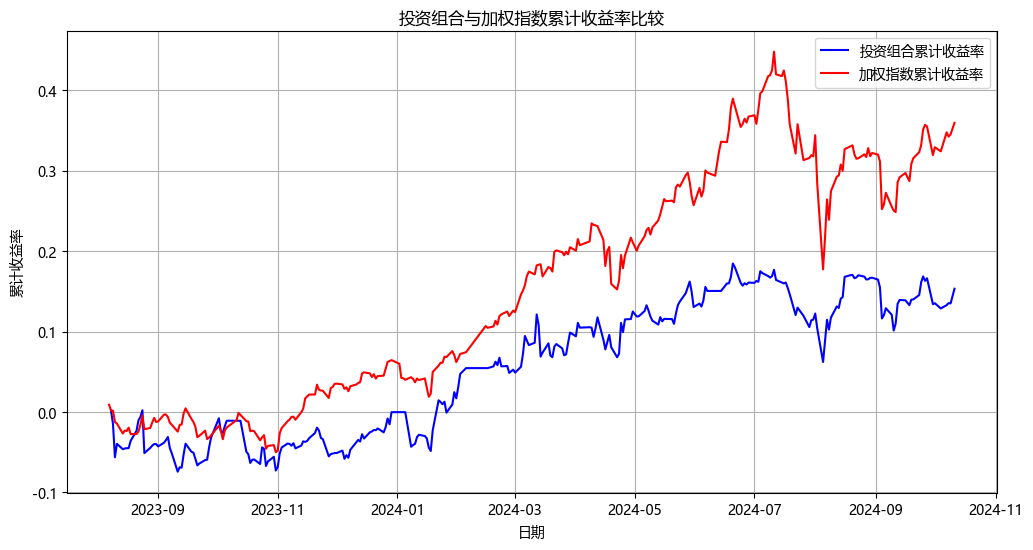

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep
from pypfopt import EfficientFrontier, expected_returns, risk_models

# 1. 读取股票价格数据
df_prices = pd.read_csv('股價.csv')

# 转换 'Date' 为日期类型
df_prices['Date'] = pd.to_datetime(df_prices['Date'])

# 数据透视，将 'ticker' 作为列，将 'Adj_Close' 作为值
df_prices = df_prices.pivot(index='Date', columns='ticker', values='Adj_Close')

# 数据清洗
df_prices.dropna(how='all', inplace=True)
df_prices = df_prices.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))
df_prices[df_prices <= 0] = np.nan

# 填充缺失值
df_prices.fillna(method='ffill', inplace=True)
df_prices.fillna(method='bfill', inplace=True)

# 将列名转换为字符串类型
df_prices.columns = df_prices.columns.astype(str)

# 2. 读取预测数据
all_predictions = pd.read_csv('predictions.csv')

# 转换数据类型
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'])
all_predictions['ticker'] = all_predictions['ticker'].astype(str)
all_predictions['Predicted_Return'] = pd.to_numeric(all_predictions['Predicted_Return'], errors='coerce')

# 3. 确保预测数据起始日期正确
# 如果预测数据中有早于 2023-07-20 的日期，进行过滤
all_predictions = all_predictions[all_predictions['Date'] >= '2023-07-20']

# 设置投资组合初始资金
initial_portfolio_value = 100000000
cash = initial_portfolio_value

# 初始化持仓和投资组合价值记录
current_allocation = {}
portfolio_value_per_day = pd.DataFrame(index=df_prices.index)
portfolio_value_per_day['Total'] = np.nan

# 获取预测数据中所有周的列表
start_date = all_predictions['Date'].min()
end_date = df_prices.index.max()
weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# 定义函数
def get_top_20_stocks(predictions_df, date):
    # 获取指定日期的预测结果
    predictions_on_date = predictions_df[predictions_df['Date'] == date]
    # 如果没有预测结果，返回空列表
    if predictions_on_date.empty:
        return [], predictions_on_date
    # 按照预测回报率排序，选出前20只股票
    top_20 = predictions_on_date.sort_values(by='Predicted_Return', ascending=False).head(20)
    # 将股票代码转换为字符串
    top_20['ticker'] = top_20['ticker'].astype(str)
    return top_20['ticker'].tolist(), top_20

def adjust_portfolio(top_stocks, valid_prices, current_allocation, cash, predictions_on_date):
    # 获取历史价格数据
    historical_data = df_prices[top_stocks].loc[:rebalance_date].dropna()

    # 如果历史数据不足，使用默认的等权重
    if historical_data.shape[0] < 2:
        weights = {stock: 1/len(top_stocks) for stock in top_stocks}
    else:
        # 使用 PyPortfolioOpt 计算预期收益率和协方差矩阵
        mu = expected_returns.mean_historical_return(historical_data)
        S = risk_models.CovarianceShrinkage(historical_data).ledoit_wolf()

        try:
            # 构建有效前沿模型，计算最大夏普比率的权重
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
            weights = cleaned_weights
        except Exception as e:
            print(f"优化时出错，使用等权重：{e}")
            weights = {stock: 1/len(top_stocks) for stock in top_stocks}

    # 确保权重的股票代码为字符串类型
    weights = {str(k): v for k, v in weights.items()}

    # 计算当前投资组合总价值
    total_portfolio_value = sum(current_allocation.get(stock, 0) * valid_prices.get(stock, 0) for stock in current_allocation) + cash

    # 计算目标持仓
    valid_prices = {k: float(v) for k, v in valid_prices.items() if pd.notna(v) and isinstance(v, (int, float))}
    target_allocations = {stock: weights[stock] * total_portfolio_value for stock in top_stocks if stock in valid_prices}
    target_shares = {stock: target_allocations[stock] / valid_prices[stock] for stock in target_allocations}

    # **先卖出需要卖出的股票**
    # 卖出未在新持仓中的股票
    for stock in list(current_allocation.keys()):
        if stock not in top_stocks:
            shares_to_sell = current_allocation[stock]
            price = valid_prices.get(stock, df_prices.loc[rebalance_date, stock])
            if pd.notna(price) and isinstance(price, (int, float)):
                proceeds = shares_to_sell * price
                cash += proceeds
                print(f"卖出 {stock} 的 {shares_to_sell:.2f} 股，获得现金 {proceeds:.2f}")
                del current_allocation[stock]

    # 卖出需要减少的股票
    for stock in top_stocks:
        if stock in current_allocation:
            target_shares_to_hold = target_shares.get(stock, 0)
            current_shares = current_allocation.get(stock, 0)
            price = valid_prices.get(stock, 0)
            if current_shares > target_shares_to_hold:
                # 卖出多余的部分
                shares_to_sell = current_shares - target_shares_to_hold
                proceeds = shares_to_sell * price
                cash += proceeds
                current_allocation[stock] = target_shares_to_hold
                print(f"卖出 {stock} 的 {shares_to_sell:.2f} 股，获得现金 {proceeds:.2f}")

    # **然后买入需要买入的股票**
    for stock in top_stocks:
        target_shares_to_hold = target_shares.get(stock, 0)
        current_shares = current_allocation.get(stock, 0)
        price = valid_prices.get(stock, 0)
        if current_shares < target_shares_to_hold:
            # 买入缺少的部分
            shares_to_buy = target_shares_to_hold - current_shares
            cost = shares_to_buy * price
            if cost <= cash:
                cash -= cost
                current_allocation[stock] = target_shares_to_hold
                print(f"买入 {stock} 的 {shares_to_buy:.2f} 股，花费现金 {cost:.2f}")
            else:
                # 现金不足，按比例购买
                affordable_shares = cash / price
                current_allocation[stock] = current_shares + affordable_shares
                cash -= affordable_shares * price
                print(f"现金不足，调整 {stock} 的买入数量为 {affordable_shares:.2f} 股，花费现金 {affordable_shares * price:.2f}")

    return current_allocation, cash

# 主循环
for week_start in weeks:
    print(f"\n处理周开始日期：{week_start.strftime('%Y-%m-%d')}")
    week_end = week_start + pd.Timedelta(days=6)  # 一周的结束日期

    # 获取本周的开始日期
    rebalance_date = week_start

    # 获取预测回报率最高的20只股票
    top_stocks, predictions_on_date = get_top_20_stocks(all_predictions, rebalance_date)
    if not top_stocks:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 没有可用的预测结果，跳过该周。")
        continue

    # 确保 df_prices 的列名是字符串类型
    df_prices.columns = df_prices.columns.astype(str)
    # 将 top_stocks 中的股票代码转换为字符串
    top_stocks = [str(stock) for stock in top_stocks]

    # 获取本周第一个交易日的价格
    try:
        week_prices = df_prices.loc[rebalance_date:week_end, top_stocks]
        earliest_prices = week_prices.iloc[0]
    except IndexError:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 没有足够的交易日，跳过该周。")
        continue
    except KeyError as e:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 发生 KeyError：{e}")
        continue

    earliest_prices = earliest_prices.dropna()
    valid_prices = earliest_prices.to_dict()

    # 过滤掉没有价格数据的股票
    top_stocks = [stock for stock in top_stocks if stock in valid_prices]
    predictions_on_date = predictions_on_date[predictions_on_date['ticker'].isin(top_stocks)]

    if not top_stocks:
        print(f"{rebalance_date.strftime('%Y-%m-%d')} 无有效的股票可交易，跳过该周。")
        continue

    # 调整投资组合
    current_allocation, cash = adjust_portfolio(top_stocks, valid_prices, current_allocation, cash, predictions_on_date)

    # 计算每日投资组合市值
    held_stocks = list(current_allocation.keys())
    if held_stocks:
        try:
            week_prices = df_prices.loc[rebalance_date:week_end, held_stocks]
            holdings = pd.Series(current_allocation)
            daily_portfolio_value = (week_prices * holdings).sum(axis=1) + cash
            portfolio_value_per_day.loc[rebalance_date:week_end, 'Total'] = daily_portfolio_value
        except Exception as e:
            print(f"{rebalance_date.strftime('%Y-%m-%d')}: 计算每日市值时出错: {e}")

# 填充缺失的投资组合市值
portfolio_value_per_day['Total'].fillna(method='ffill', inplace=True)

# 计算投资组合的每日收益率和累计收益率
daily_returns = portfolio_value_per_day['Total'].pct_change().dropna()
portfolio_value_per_day['Cumulative Returns'] = (1 + daily_returns).cumprod() - 1

# 使用 empyrical 计算投资组合的绩效指标
annual_return = ep.annual_return(daily_returns)
sharpe_ratio = ep.sharpe_ratio(daily_returns)
max_drawdown = ep.max_drawdown(daily_returns)

print("\n=== 投资组合绩效指标 ===")
print(f"年化收益率: {annual_return:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")

# 读取加权指数数据
index_prices = pd.read_csv('TWII.csv')
index_prices['Date'] = pd.to_datetime(index_prices['Date'])
index_prices.set_index('Date', inplace=True)
index_prices.sort_index(inplace=True)

# 确保加权指数数据起始日期正确
index_prices = index_prices[index_prices.index >= start_date]

# 将 'Close' 列的字符串转换为浮点数
index_prices['Close'] = index_prices['Close'].astype(str).str.replace(',', '').astype(float)

# 对齐指数数据和投资组合数据的日期范围
common_dates = portfolio_value_per_day.index.intersection(index_prices.index)
index_prices = index_prices.loc[common_dates]
portfolio_value_per_day = portfolio_value_per_day.loc[common_dates]

# 计算加权指数的每日收益率和累计收益率
index_prices['Index Returns'] = index_prices['Close'].pct_change()
index_prices['Index Cumulative Returns'] = (1 + index_prices['Index Returns']).cumprod() - 1

# 计算加权指数的绩效指标
index_daily_returns = index_prices['Index Returns'].dropna()
index_annual_return = ep.annual_return(index_daily_returns)
index_sharpe_ratio = ep.sharpe_ratio(index_daily_returns)
index_max_drawdown = ep.max_drawdown(index_daily_returns)

print("\n=== 加权指数绩效指标 ===")
print(f"年化收益率: {index_annual_return:.2%}")
print(f"夏普比率: {index_sharpe_ratio:.2f}")
print(f"最大回撤: {index_max_drawdown:.2%}")

# 绘制投资组合和加权指数的累计收益率比较图
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_per_day.index, portfolio_value_per_day['Cumulative Returns'], label='投资组合累计收益率', color='blue')
plt.plot(index_prices.index, index_prices['Index Cumulative Returns'], label='加权指数累计收益率', color='red')
plt.title('投资组合与加权指数累计收益率比较')
plt.xlabel('日期')
plt.ylabel('累计收益率')
plt.legend()
plt.grid(True)
plt.show()
